In [1]:
import collections
import itertools
import json
import pathlib

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(8,8)})
import sklearn.metrics
import tqdm

In [2]:
PARENT = pathlib.Path(globals()['_dh'][0]).parent
MODELS_PATH = PARENT / 'models-wsd'
DATA_PATH = PARENT / 'data' / 'drop'
KEYS_TO_SUM = ['ipt', 'norm', 'mha', 'ff']
DEVICE = 'cpu'

def powerset():
    yield from (
        # four singletons
        ('ipt',),
        ('mha',),
        ('ff',),
        ('norm',),
        # six duals
        ('ipt', 'mha',),
        ('ipt', 'ff',),
        ('ipt', 'norm',),
        ('mha', 'ff'),
        ('norm', 'mha',),
        ('norm', 'ff',),
        # four triplets
        ('ipt', 'mha', 'ff'),
        ('ipt', 'norm', 'mha',),
        ('ipt', 'norm', 'ff',),
        ('norm', 'mha', 'ff',),
        # one full
        ('ipt', 'norm', 'mha', 'ff',),
        
    )
    # combinations = (
    #    itertools.combinations(KEYS_TO_SUM, r)
    #    for r in range(1, len(KEYS_TO_SUM) + 1)
    #)
    #yield from itertools.chain.from_iterable(combinations)

DROP_MONOSEMOUS = True

def build_refs():
    """build references for easier computations: dict {lemma -> [tags]}"""
    refs = collections.defaultdict(set)
    from nltk.corpus import semcor
    for sentence in semcor.tagged_sents(tag='sem'):
        for word in sentence:
            try:
                key = word.label().name()
                value = word.label().key()
                refs[key].add(value)
            except AttributeError:
                if type(word) not in (list, str):
                    assert type(word.label()) == str
                    key = word.label().split('.', 1)[0]
                    value = word.label()
                    refs[key].add(value)
    if DROP_MONOSEMOUS:
        return {
            k: sorted(list(v))
            for k, v in refs.items()
            if len(v) > 1
        }
    return {
        k: sorted(list(v))
        for k, v in refs.items()
    }

def build_or_get_refs(REFS_FILENAME="../refs-semcor.json"):
    if pathlib.Path(REFS_FILENAME).is_file():
        with open(REFS_FILENAME, 'r') as istr:
            return json.load(istr)
    else:
        refs = build_refs()
        with open(REFS_FILENAME, 'w') as ostr:
            json.dump(refs, ostr)
        return refs

refs = build_or_get_refs()
refs_itos = sorted(refs.keys())
refs_stoi = {
    lemma: idx
    for idx, lemma in enumerate(refs_itos)
}
tags_stoi = {
    tag: torch.tensor([idx], dtype=torch.long)
    for idx, tag in enumerate(
        item
        for lemma in refs_stoi
        for item in refs[lemma]
    )
}

def build_lemma_mask(lemma):
    mask = torch.tensor([True] * len(tags_stoi))
    for valid_tag in refs[lemma]:
        mask[tags_stoi[valid_tag].item()] = False
    return mask

lemma_masks = {
    lemma: build_lemma_mask(lemma)
    for lemma in refs_stoi
}

def overlap(a_start, a_end, b_start, b_end):
    """determine whether a and b overlap"""
    return (a_start <= b_start and a_end > b_start) \
        or (a_start < b_end and a_end >= b_end) \
        or (a_start <= b_start and a_end >= b_end) \
        or (a_start >= b_start and a_end <= b_start)

def toks_to_str(tokens):
    """return a clean str represnting the original tokens"""
    return " ".join(tokens).replace('``', '"').replace("''", '"')

    
class BertFactorSemcorDataset(Dataset):
    """torch object for convenience"""
    def __init__(self, file_name, tokenizer_=None, model_=None):
        raise NotImplemented

    def save(self, file):
        torch.save(self, file)

    @staticmethod
    def load(file):
        return torch.load(file)

    def __getitem__(self, idx):
        base_dict = self.items[idx]
        if not 'tgt_idx' in base_dict:
            base_dict['tgt_idx'] = tags_stoi[base_dict['tag']]
            base_dict['tgt_idx'].requires_grad = False
            base_dict['lemma_mask'] = lemma_masks[base_dict['lemma']]
            base_dict['lemma_mask'].requires_grad = False
        return base_dict

    def __len__(self):
        return len(self.items)


In [3]:
@torch.no_grad()
def eval_model(keys_to_sum, model_name, dataset, return_preds=False):
    wsd_model = torch.load(model_name, map_location='cpu')
    pbar = tqdm.notebook.tqdm(dataset, desc="Test", leave=False, disable=None)
    all_true = []
    all_preds = []
    all_targets = []
    wsd_model.eval()
    running_loss, total_items = 0, 0
    total_acc = 0
    for batch in pbar:
        all_ipts = sum(batch[key].to(DEVICE) for key in keys_to_sum)
        mlp_output = wsd_model(all_ipts)
        tgt = batch['tgt_idx'].view(-1).to(DEVICE)
        all_targets.extend(tgt.tolist())
        lemma_specific_output = mlp_output.masked_fill(batch['lemma_mask'].to(DEVICE), -float('inf'))
        loss = F.cross_entropy(lemma_specific_output, tgt, reduction='sum')
        lemma_preds = F.softmax(lemma_specific_output, dim=-1).argmax(dim=-1).view(-1)
        all_preds.extend(lemma_preds.detach().tolist())
        acc = (lemma_preds == tgt).sum()
        running_loss += loss.item()
        total_acc += acc.item()
        total_items += batch['tgt_idx'].numel()
        pbar.set_description(f"Test (L={running_loss/total_items:.4f}, A={total_acc/total_items:.4f})")
    #new_f1 = sklearn.metrics.f1_score(all_true, all_preds, average='micro')
    #print(model_subdir, model_name, new_f1)
    if return_preds:
        return all_preds
    return total_acc/total_items

In [4]:
def get_best_models(path_to_models, path_to_data):
    path_to_test_set = path_to_data / 'test.pt'
    dataset = DataLoader(BertFactorSemcorDataset.load(path_to_test_set), shuffle=False, batch_size=512)
    all_results = []
    for run in range(1, 6):
        all_results.append([])
        for keys in powerset():
            model_name = path_to_models / str(run) / ("_".join(keys) + f'.{run}.pt')
            f1 = eval_model(keys, model_name, dataset)
            all_results[-1].append(f1)
    return all_results
    
all_wsd_f1 = np.array(get_best_models(MODELS_PATH, DATA_PATH))* 100

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

In [5]:
grad_cmds = ["\\" + f'grad{chr(c)}' for c in range(ord('A'), ord('O')+1)]
def get_ranks(run):
    ranks = np.empty_like(run)
    ranks[run.argsort()] = np.arange(run.shape[0])
    return ranks

shades  = np.array([get_ranks(run) for run in all_wsd_f1]).astype(int)
best_run = all_wsd_f1.argmax(0)
individual_cells = [[] for _ in range(5)]
for key_idx in range(all_wsd_f1.shape[1]):
    for run_idx in range(all_wsd_f1.shape[0]):
        grad_cmd = grad_cmds[shades[run_idx,key_idx]]
        score = str(all_wsd_f1[run_idx,key_idx]) 
        if best_run[key_idx] == run_idx:
            cell_value = "{" + grad_cmd + "\\bestCell{" + score + "}}"
        else:
            cell_value = "{" + grad_cmd + "} " + score
        individual_cells[run_idx].append(cell_value)
print(*[" &&\n" + " & ".join(single_run) +"\n\\\\" for single_run in individual_cells ], sep="\n")

 &&
{\gradC\bestCell{58.415119735292464}} & {\gradN} 66.83865178621502 & {\gradF} 64.46077056811171 & {\gradA} 57.32151870338175 & {\gradL} 66.65358084235321 & {\gradD} 63.883124894846055 & {\gradB\bestCell{57.82625764118669}} & {\gradH} 65.71140149178397 & {\gradO\bestCell{66.94520778419606}} & {\gradG} 64.46077056811171 & {\gradI} 65.75626717514442 & {\gradM\bestCell{66.77135326117435}} & {\gradE} 64.4495541472716 & {\gradJ} 65.87964780438563 & {\gradK} 65.98620380236666
\\
 &&
{\gradC} 57.91038079748753 & {\gradL} 66.5189837922719 & {\gradG} 64.73557287869441 & {\gradA} 57.40003364926252 & {\gradM} 66.68723010487354 & {\gradD} 64.23083394088947 & {\gradB} 57.65801132858505 & {\gradI} 65.96377096068645 & {\gradO} 66.8050025236947 & {\gradE} 64.387863832651 & {\gradH\bestCell{65.93572990858617}} & {\gradN} 66.72648757781391 & {\gradF} 64.56171835567271 & {\gradJ} 65.98620380236666 & {\gradK} 66.02546127530705
\\
 &&
{\gradC} 58.308563737311424 & {\gradL} 66.38999495261062 & {\gradG} 6

In [6]:
means = all_wsd_f1.mean(0)
shades = get_ranks(means).astype(int)
single_run = []
for key_idx in range(all_wsd_f1.shape[1]):
    grad_cmd = grad_cmds[shades[key_idx]]
    score = str(means[key_idx]) 
    cell_value = "{" + grad_cmd + "} " + score
    single_run.append(cell_value)
print(" & ".join(single_run), sep="\n")


print(" & ".join("{{$\pm$\\numprint{" + s + "}}}" for s in  all_wsd_f1.std(0).astype(str)))

{\gradC} 58.09320845718131 & {\gradL} 66.67937861028545 & {\gradG} 64.61780045987325 & {\gradA} 57.321518703381756 & {\gradM} 66.68050025236947 & {\gradD} 64.28691604509001 & {\gradB} 57.64006505524087 & {\gradK} 65.96152767651841 & {\gradO} 66.71527115697381 & {\gradF} 64.50675789355617 & {\gradH} 65.84039033144524 & {\gradN} 66.68610846278952 & {\gradE} 64.46750042061578 & {\gradI} 65.92451348774605 & {\gradJ} 65.95143289776232
{{$\pm$\numprint{0.24926208399783928}}} & {{$\pm$\numprint{0.23890186487584097}}} & {{$\pm$\numprint{0.14165589075559415}}} & {{$\pm$\numprint{0.07746641982987944}}} & {{$\pm$\numprint{0.227070892573597}}} & {{$\pm$\numprint{0.23466189256378156}}} & {{$\pm$\numprint{0.18232808727466568}}} & {{$\pm$\numprint{0.16271930426807737}}} & {{$\pm$\numprint{0.1729657923948243}}} & {{$\pm$\numprint{0.13784794118770383}}} & {{$\pm$\numprint{0.08010126665406082}}} & {{$\pm$\numprint{0.1153929327540729}}} & {{$\pm$\numprint{0.15680540288084058}}} & {{$\pm$\numprint{0.11667

In [7]:

DEVICE = 'cpu'

@torch.no_grad()
def best_preds_to_matrix(filename, untuned=True):
    best_runs_considered = best_run 
    path_to_test_set = DATA_PATH /  'test.pt'
    dataset = DataLoader(BertFactorSemcorDataset.load(path_to_test_set), shuffle=False, batch_size=512)
    all_preds = {}
    for run, keys_to_sum in zip(best_runs_considered.tolist(), powerset()):
        run += 1
        model_name = MODELS_PATH / f'{run}' / ("_".join(keys_to_sum) + f'.{run}.pt')
        all_preds[keys_to_sum] = eval_model(keys_to_sum, model_name, dataset, return_preds=True)
    matrix_view = np.zeros((len(all_preds), len(all_preds)))
    for i, keys_1 in enumerate(powerset()):
        for j, keys_2 in enumerate(powerset()):
            matrix_view[i, j] = sklearn.metrics.f1_score(all_preds[keys_1], all_preds[keys_2], average='micro')
    # print(matrix_view.tolist())
    np.save(filename, matrix_view)

In [8]:
best_preds_to_matrix('../data/all-best-f1-classif-semcor.npy')

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

Test:   0%|          | 0/35 [00:00<?, ?it/s]

In [9]:
def matrix_to_heatmap(matrix_dump): # 'f1-classif-semcor.npy'

    data = np.load(matrix_dump)
    mask = np.triu(data)
    data = data[1:,:-1]
    mask = mask[1:,:-1]

    keys_in_order = [
        ('I',), ('H',), ('F',), ('C',),
        ('I', 'H'), ('I', 'F'), ('I', 'C'), ('H', 'F'), ('H', 'C'), ('F', 'C'),
        ('I', 'H', 'F'), ('I', 'H', 'C'),  ('I', 'F', 'C'), ('H', 'F', 'C'),
        ('I', 'H', 'F', 'C')
    ]

    labels = ["+".join(l) for l in keys_in_order]

    sns.heatmap(data, vmin=0, vmax=1, annot=True, square=True, xticklabels=labels[:-1], yticklabels=labels[1:], cmap="flare", mask=mask, cbar=False)

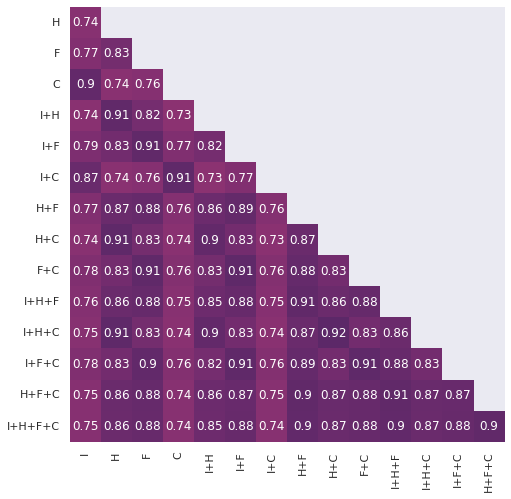

In [10]:
matrix_to_heatmap('../data/all-best-f1-classif-semcor.npy')